In [1]:
import numpy as np
import sklearn
import os
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from cnn import Net

%load_ext autoreload
%autoreload 2

In [2]:
CLEANED_DIR = '/projectnb2/dl523/projects/trace_22/data/cleaned'
# DATASET_PICKLE = [traces, images, tokens, expressions]
path = os.path.join(CLEANED_DIR, 'dataset_cleaned_125.pkl')

with open(path, 'rb') as f:
    dataset = pickle.load(f)
          
print((len(dataset), len(dataset[0])))

(4, 10939)


In [3]:
v = []
tokens = dataset[2]
for token in tokens:
    for item in token.split():
        v.append(item)
        
np.unique(v)
len(np.unique(v))

125

In [4]:
def clean(dataset, vocab):
    '''Remove samples for which there is a token not included in the vocabulary.'''
    tokens = dataset[2]
    removed = []
    vocab = set(vocab)
    print(len(dataset[0]))
    for idx in reversed(range(len(tokens))):
        for token in tokens[idx].split():
            if not token in vocab:
                print(idx, token)
                removed.append(tuple(dataset[i].pop(idx) for i in range(4)))
                
    print(len(dataset[0]))
    return removed, dataset
                           
rem_cleaned, dataset = clean(dataset, vocab=vocab)

NameError: name 'vocab' is not defined

In [ ]:
CLEANED_DIR = '/projectnb2/dl523/projects/trace_22/data/cleaned'
path = os.path.join(CLEANED_DIR, 'dataset_cleaned_125.pkl')
with open(path, 'wb') as f:
    pickle.dump(dataset, f)
          
print('Saved pickled dataset at ', path)

In [ ]:
images, tokens = dataset[1], dataset[2]

### Hold out

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, tokens, test_size=1/4)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

### Load vocab

In [ ]:
# load vocabulary

with open('/projectnb2/dl523/projects/trace_22/data/vocab.txt', 'r') as f:
    vocab = f.read().split('\n')
    
print(len(vocab))

### Visualize target lengths (i.e. how many tokens is one expression?)

In [ ]:
L = []

for tok in tokens:
    L.append(len(tok))
    
print(np.max(L))
print(np.argmax(L))
plt.hist(L, bins=40)
plt.ylabel('occurences')
plt.xlabel('token length')

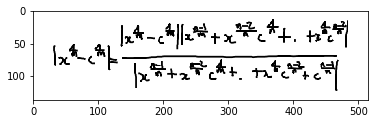

In [38]:
plt.imshow(images[7278], cmap='gray')

### Cutoff tokens longer than length 150

Like mentioned in the paper (A Visual Latex Decompiler), we remove training samples with tokens longer than 150. However, we leave them in for testing.

We would thus remove 23 samples from the training set.

In [39]:
L = np.array(L)

(L>150).sum()
((L>150).sum()) / len(L)

0.0021008403361344537

In [57]:
def cutoff(X, y, token_length):
    '''Remove samples from X an y where y has a token length > 150.'''
    removed = []
    for idx in reversed(range(len(y))):
        if len(y[idx]) > token_length:
            print(idx)
            removed.append((X[idx], y[idx]))
    return removed
                           
rem = cutoff(X_train, y_train, token_length=150)

7472
6369
5776
5476
5238
4570
4172
3649
3177
3128
2801
2546
2448
2337
1056
472


## Dataset object

In [9]:
# load encoder
DATA = '/projectnb/dl523/projects/trace_22/data/'

vocab = np.load(DATA + 'labelencoding.npy')
vocab

array(['!', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '<', '=', '>', 'A', 'B', 'C', 'E',
       'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V',
       'X', 'Y', '[', '\\', '\\!', '\\;', '\\Big', '\\Bigg', '\\Delta',
       '\\alpha', '\\beta', '\\cdot', '\\cdots', '\\cos', '\\div',
       '\\exists', '\\forall', '\\frac', '\\gamma', '\\geq', '\\gt',
       '\\hbox', '\\in', '\\infty', '\\int', '\\lambda', '\\lbrack',
       '\\ldots', '\\left', '\\leq', '\\lim', '\\limits', '\\log', '\\lt',
       '\\mathrm', '\\mbox', '\\mu', '\\neq', '\\parallel', '\\phi',
       '\\pi', '\\pm', '\\prime', '\\rbrack', '\\right', '\\rightarrow',
       '\\sigma', '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta',
       '\\times', '\\{', '\\}', ']', '^', '_', 'a', 'b', 'c', 'd', 'e',
       'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
       's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}'],
      dtype='<U11

In [10]:
from tools.encode import train_label_encoding, OneHotEncoder

label_enc = train_label_encoding(vocab)

In [40]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader

input_shape=(250, 490)

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_shape),
            transforms.ToTensor(), # This also normalizes the image
        ])

target_transform = OneHotEncoder(label_enc)

class ImgTokenDataset(Dataset):
    def __init__(self, images, tokens, transform=transform, target_transform=target_transform, vocab=vocab):
        self.images = images
        self.tokens = tokens
        self.transform = transform
        self.target_transform = target_transform
        self.vocab = vocab

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.tokens[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target
    
    
train_data = ImgTokenDataset(X_train, y_train, transform=transform, target_transform=target_transform, vocab=vocab)
    
test_data = ImgTokenDataset(X_test, y_test, transform=transform, target_transform=target_transform, vocab=vocab)

In [219]:
trainloader = DataLoader(train_data, batch_size=28, shuffle=True)
testloader = DataLoader(test_data, batch_size=28, shuffle=True)

## CNN Model

In [268]:
from cnn import Net

import torch.optim as optim
print('loading...')
net = Net(input_shape, vocab)

criterion = nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if we set the hardware to GPU in the Notebook settings, this should print a CUDA device:
# device = 'cpu'

print(device)

net.to(device)

loading...
cuda:0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=115200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=126, bias=True)
)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    print('start')
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()   # zero the gradient buffers
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [238]:
def test_cnn(net, testLoader, threshold=0.5):
    correct = []
    total = []
    
    with torch.no_grad():
        for idx, data in enumerate(testLoader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            
            for sample in range(len(outputs.cpu())):
                preds = np.where(outputs[sample].cpu()>threshold)[0]
                labels_ = np.where(labels[sample].cpu()==1)[0]
                if len(labels_) < 1:
                    continue
                intersection = set(preds) & set(labels_)
                total.append(len(labels_))
                correct.append(len(intersection))
        return np.array(correct), np.array(total)

In [243]:
correct, total = test_cnn(net, testloader)

In [240]:
len(correct)

2734

In [244]:
acc = correct / total

print(acc.std())
print(acc.mean())

0.24382155987974446
0.33117625994391686


# Cross validation with 5 folds

In [274]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)
cv.get_n_splits(images, tokens)

ACC = []
HIST = []

BS = 28
    
data = ImgTokenDataset(images, tokens, transform=transform, target_transform=target_transform, vocab=vocab)
for fold, (train_index, test_index) in enumerate(cv.split(images)):
    
    HIST.append([])
    
    print('Fold: ', fold)
    # Setup data

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_index)

    trainloader = torch.utils.data.DataLoader(
                      data, 
                      batch_size=BS, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      data,
                      batch_size=BS, sampler=test_subsampler)

    # Model
    net = Net(input_shape, vocab)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.to(device)
    # Train
    for epoch in range(10):  # loop over the dataset multiple times
        print('Epoch: ', epoch)
        for i, d in enumerate(trainloader, 0):
            inputs, labels = d
        
            inputs, labels = inputs.to(device), labels.to(device)
            #inputs = inputs.cuda()
            #labels = labels.cuda()
            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
                HIST[fold].append(loss.item())
                
    correct, total = test_cnn(net, testloader)
    acc = correct / total

    print('Accuracy: ')
    print(f'{acc.mean():.3f} +/- {(acc.std()/2):.2f}')
    print()
    ACC.append(acc)
    
                      
print('Finished Training')

Fold:  0
Epoch:  0
[1,    50] loss: 0.199
[1,   100] loss: 0.185
[1,   150] loss: 0.179
[1,   200] loss: 0.197
[1,   250] loss: 0.173
[1,   300] loss: 0.175
Epoch:  1
[2,    50] loss: 0.158
[2,   100] loss: 0.166
[2,   150] loss: 0.143
[2,   200] loss: 0.179
[2,   250] loss: 0.173
[2,   300] loss: 0.176
Epoch:  2
[3,    50] loss: 0.163
[3,   100] loss: 0.154
[3,   150] loss: 0.165
[3,   200] loss: 0.155
[3,   250] loss: 0.146
[3,   300] loss: 0.153
Epoch:  3
[4,    50] loss: 0.148
[4,   100] loss: 0.162
[4,   150] loss: 0.133
[4,   200] loss: 0.137
[4,   250] loss: 0.143
[4,   300] loss: 0.162
Epoch:  4
[5,    50] loss: 0.156
[5,   100] loss: 0.146
[5,   150] loss: 0.128
[5,   200] loss: 0.149
[5,   250] loss: 0.136
[5,   300] loss: 0.148
Epoch:  5
[6,    50] loss: 0.146
[6,   100] loss: 0.143
[6,   150] loss: 0.135
[6,   200] loss: 0.131
[6,   250] loss: 0.147
[6,   300] loss: 0.124
Epoch:  6
[7,    50] loss: 0.117
[7,   100] loss: 0.139
[7,   150] loss: 0.140
[7,   200] loss: 0.138
[

In [296]:
mean_accs = []
for vals in ACC:
    mean_accs.append(np.mean(vals))

print(np.mean(mean_accs))
print(np.std(mean_accs))

0.34337621221654757
0.009582636488895168


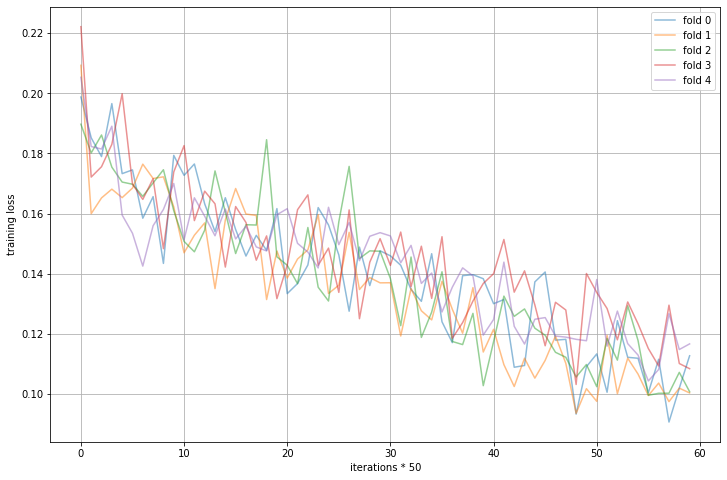

In [298]:
plt.figure(figsize=(12,8))

for fold in range(5):
    plt.plot(list(range(len(HIST[fold]))), HIST[fold], label=f'fold {fold}', alpha=0.5)
    
# plt.xticks(labels=str(50*np.arange(len(HIST[fold]))))
plt.xlabel('iterations * 50')
plt.ylabel('training loss')
plt.legend()
plt.grid()